In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import tempfile
from itertools import product

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_noise')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K4me1']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [3]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

# Summary Jacard

In [4]:
# Load immune bad quality dataset
mln_bench_df_all = pd.concat([
    pd.read_csv(GSE26320_PATH_HG38 + f'/{m}_mln_bench_df.csv')
    for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
]).reset_index(drop=True)
mln_bench_df_all.sample(5)

,cell,replicate,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard,q,modification
124,GM12878,rep2,SICER,31704,108935496,7,24482,115889918,25651,24433,99978349,0.997999,0.809078,8.936628e-01,0.862701,0.917776,8.893865e-01,0.800807,0,H3K27ac
418,Huvec,rep1,MACS2 broad,39039,85269094,2,0,0,0,0,0,0.000000,0.000000,1.000000e-10,0.000000,0.000000,1.000000e-10,0.000000,2,H3K36me3
431,Huvec,rep2,MACS2,3389,1380886,1,0,0,0,0,0,0.000000,0.000000,1.000000e-10,0.000000,0.000000,1.000000e-10,0.000000,3,H3K36me3
120,GM12878,rep2,SPAN,31050,70478499,7,29522,68506521,29022,29082,66172123,0.985096,0.934686,9.592291e-01,0.965924,0.938898,9.522195e-01,0.908797,0,H3K27ac
116,GM12878,rep2,MACS2 broad,28199,57515282,7,30354,32204975,20271,30354,32202299,1.000000,0.718855,8.364349e-01,0.999917,0.559891,7.178379e-01,0.559865,0,H3K27ac


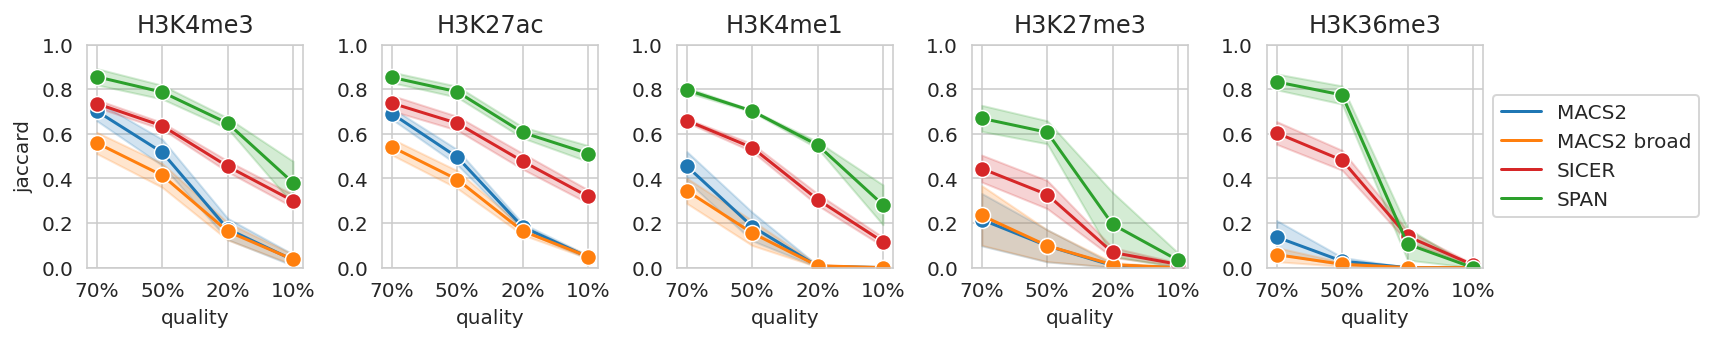

In [5]:
plt.figure(figsize=(12, 2.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=mln_bench_df_all[mln_bench_df_all['modification']==m],
                             x='q', y='jaccard', hue='name',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=8
                             )
    g_results.axes.set_xticks(range(4), minor=False)
    # g_results.axes.set_xticklabels(['7M', '5M', '2M', '1M'])
    g_results.axes.set_xticklabels(['70%', '50%', '20%', '10%'])
    g_results.axes.set_xlabel('quality')
    g_results.axes.set_ylabel('jaccard')
    g_results.axes.title.set_text(f'{m}')
    ax.set_ylim([0, 1.0])
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 +  f'/pics/jaccard_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [6]:
t = pd.DataFrame(data=[(m, c, r, t, 10, 1.0, -1)
                       for m, c, r, t in tqdm(product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                                                      GSE26320_CELLS, GSE26320_REPS, TOOLS))],
                 columns=['modification', 'cell', 'replicate', 'name', 'quality', 'jaccard', 'q'])
mln_bench_df_all = pd.concat([mln_bench_df_all, t]).reset_index(drop=True)
mln_bench_df_all.sample(5)

0it [00:00, ?it/s]

,cell,replicate,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard,q,modification
737,GM12878,rep2,MACS2 broad,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1,H3K36me3
59,K562,rep2,SPAN,28083.0,48448206.0,1,13572.0,27879848.0,13628.0,13496.0,26792178.0,0.9944,0.485276,0.652249,0.960987,0.553007,0.702027,0.540864,3,H3K4me3
50,K562,rep2,MACS2,32386.0,28239409.0,2,9496.0,4697610.0,7479.0,9496.0,4697542.0,1.0000,0.230933,0.375216,0.999986,0.166347,0.285244,0.166347,2,H3K4me3
223,GM12878,rep2,SICER,51620.0,196154180.0,1,5527.0,20220673.0,4755.0,5527.0,19736210.0,1.0000,0.092115,0.168692,0.976041,0.100616,0.182426,0.100368,3,H3K4me1
401,K562,rep2,MACS2 broad,20907.0,36378540.0,5,35.0,16579.0,26.0,35.0,16579.0,1.0000,0.001244,0.002484,1.000000,0.000456,0.000911,0.000456,1,H3K36me3


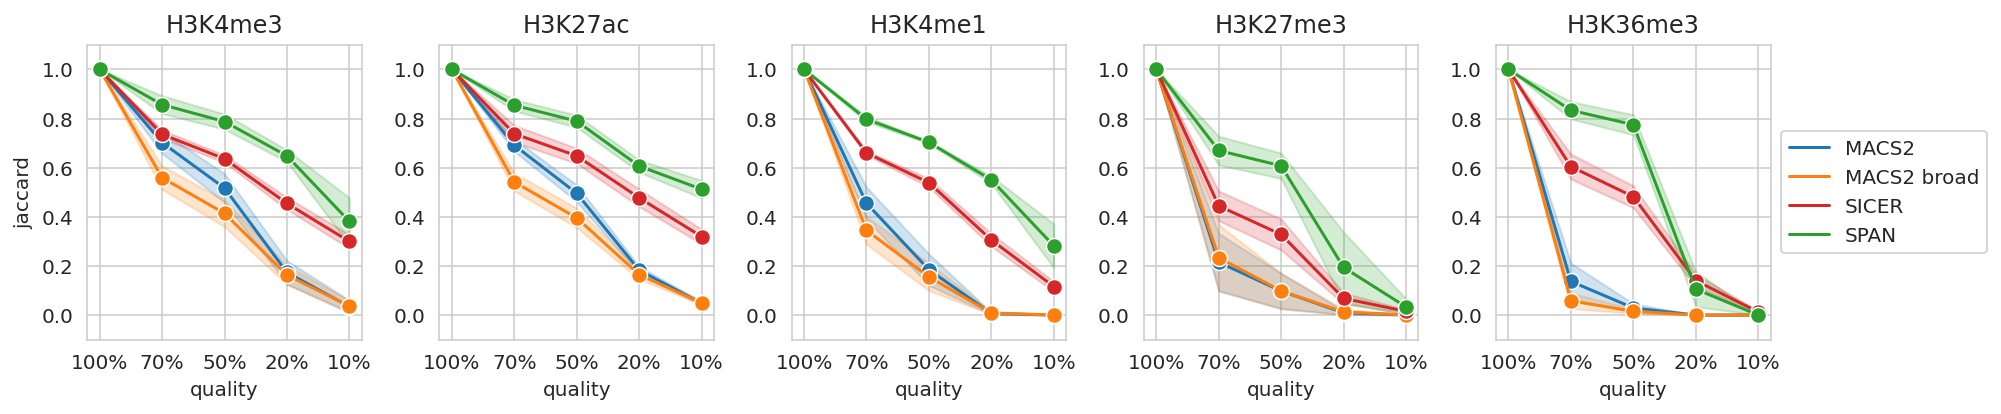

In [7]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=mln_bench_df_all[mln_bench_df_all['modification']==m],
                             x='q', y='jaccard', hue='name',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=8
                             )
    g_results.axes.set_xticks([-1, 0, 1, 2, 3], minor=False)
    # g_results.axes.set_xticklabels(['5M', '2M'])
    g_results.axes.set_xticklabels(['100%', '70%', '50%', '20%', '10%'])
    g_results.axes.set_xlabel('quality')
    g_results.axes.set_ylabel('jaccard')
    g_results.axes.title.set_text(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 +  f'/pics/jaccard_all3.pdf', bbox_inches='tight', dpi=300)
plt.show()

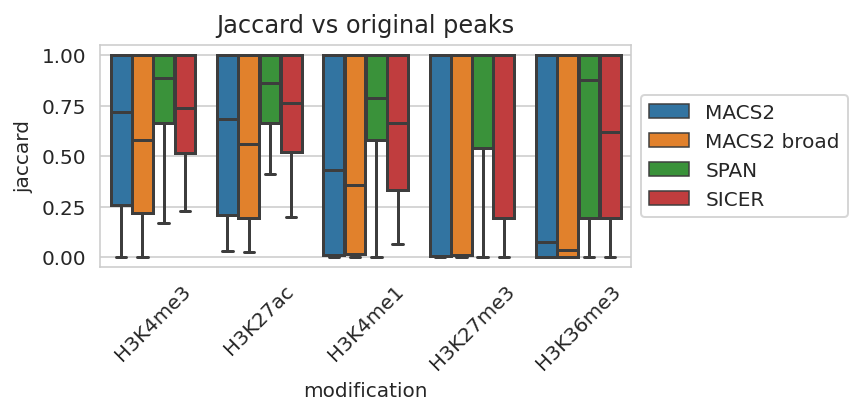

In [8]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=mln_bench_df_all,
                        x='modification', y='jaccard', hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Jaccard vs original peaks')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 +  f'/pics/jaccard_all2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Jaccard AUC

In [9]:
t = []
for m, c, r, tool in tqdm(product(mln_bench_df_all['modification'].unique(),
                                  mln_bench_df_all['cell'].unique(),
                                  mln_bench_df_all['replicate'].unique(),
                                  mln_bench_df_all['name'].unique())):
    # print(c, r, tool)
    dft = mln_bench_df_all[(mln_bench_df_all['modification'] == m) &
                           (mln_bench_df_all['cell'] == c) &
                           (mln_bench_df_all['replicate'] == r) &
                           (mln_bench_df_all['name'] == tool)].copy()
    dft.sort_values(by=['q'], inplace=True)
    if len(dft) != 5:
        continue
    dft['q'] = [0.1, 0.2, 0.5, 0.7, 1.0]
    aj = 0
    qprev = 0
    for _, row in dft.iterrows():
        aj += (row['q'] - qprev) * row['jaccard']
        qprev = row['q']
        t.append((m, c, r, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'cell', 'replicate', 'tool', 'AUC'])
dfjaccardauc

0it [00:00, ?it/s]

,modification,cell,replicate,tool,AUC
0,H3K4me3,GM12878,rep1,MACS2,0.100000
1,H3K4me3,GM12878,rep1,MACS2,0.154067
2,H3K4me3,GM12878,rep1,MACS2,0.237447
3,H3K4me3,GM12878,rep1,MACS2,0.241304
4,H3K4me3,GM12878,rep1,MACS2,0.241314
...,...,...,...,...,...
535,H3K36me3,Huvec,rep2,SICER,0.100000
536,H3K36me3,Huvec,rep2,SICER,0.152419
537,H3K36me3,Huvec,rep2,SICER,0.318274
538,H3K36me3,Huvec,rep2,SICER,0.347907


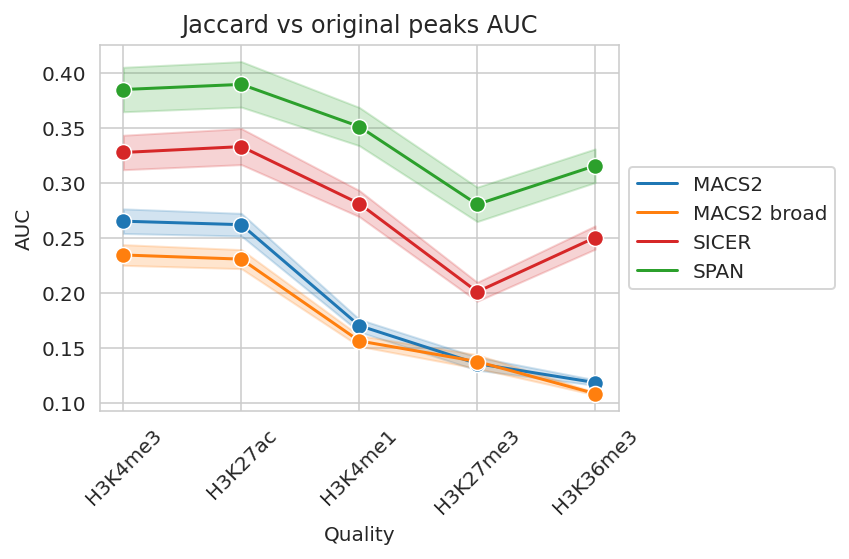

In [10]:
plt.figure(figsize=(6, 4))
g_results = sns.lineplot(data=dfjaccardauc,
                         x='modification', y='AUC', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar=('se', 0.5), marker='o', markersize=8)
g_results.axes.set_xlabel('Quality')
g_results.axes.title.set_text(f'Jaccard vs original peaks AUC')
g_results.axes.xaxis.set_tick_params(rotation=45)
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 +  f'/pics/jaccard_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Summary Jaccard replicates

In [11]:
reps_overlap_all = pd.concat([
    pd.read_csv(GSE26320_PATH_HG38 + f'/{m}_replicates_df.csv')
    for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
]).reset_index(drop=True)
reps_overlap_all.sample(5)

,modification,quality,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks2_overlap,peaks_overlap_len,diff1,diff2,jaccard,jaccardp,q
280,H3K27me3,1,K562,MACS2,rep1,rep2,0,0,0,0,0,0,0,0,0,0.000000,0.000000,4
85,H3K27ac,10,HSMM,MACS2 broad,rep1,rep2,44198,70544930,38646,49252035,32019,33768,43024093,12179,4878,0.560407,0.789666,0
320,H3K36me3,7,GM12878,MACS2,rep1,rep2,4,1541,542,202319,1,1,164,3,541,0.000805,0.003663,1
314,H3K36me3,10,Huvec,SICER,rep1,rep2,36266,163421334,31178,260866422,28019,18803,117709309,8247,12375,0.383945,0.730994,0
194,H3K4me1,7,K562,SICER,rep1,rep2,60065,160450335,52853,144737947,44895,45458,109684301,15170,7395,0.561034,0.799163,1


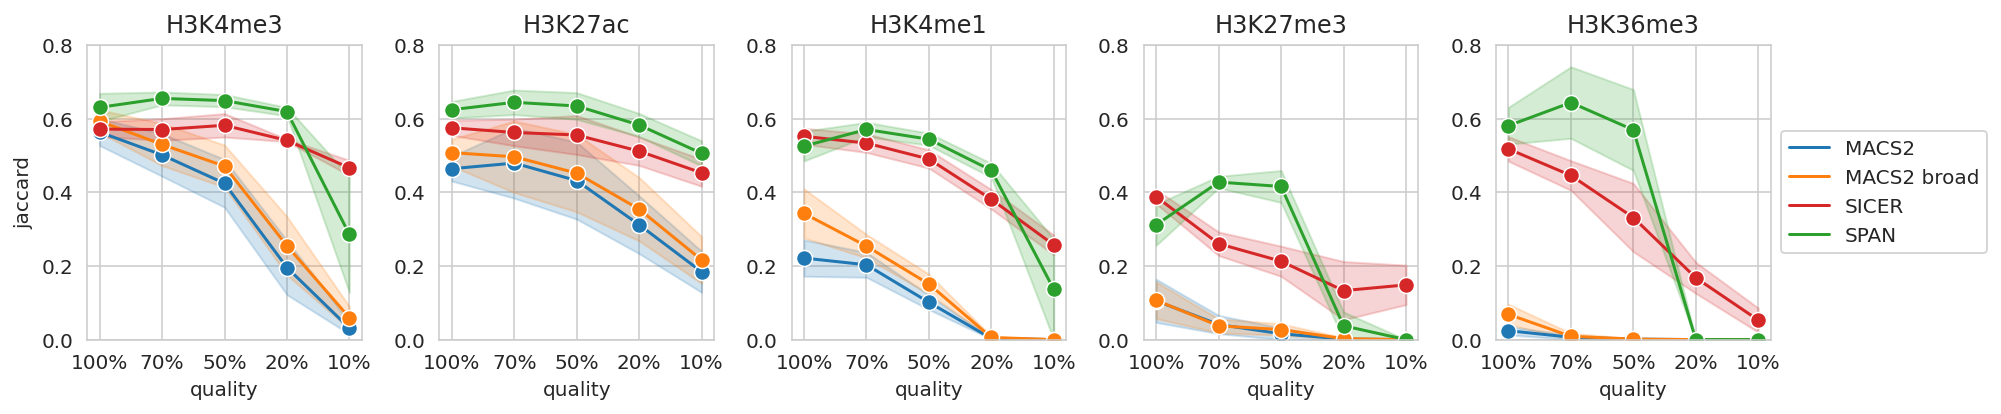

In [12]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=reps_overlap_all[reps_overlap_all['modification'] == m],
                             x='q', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=8
                             )
    g_results.axes.set_xticks(range(5), minor=False)
    # g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
    g_results.axes.set_xticklabels(['100%', '70%', '50%', '20%', '10%'])
    g_results.axes.set_xlabel('quality')
    g_results.axes.set_ylabel('jaccard')
    g_results.axes.title.set_text(f'{m}')
    ax.set_ylim([0, .8])
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)

plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/replicates_jaccard_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

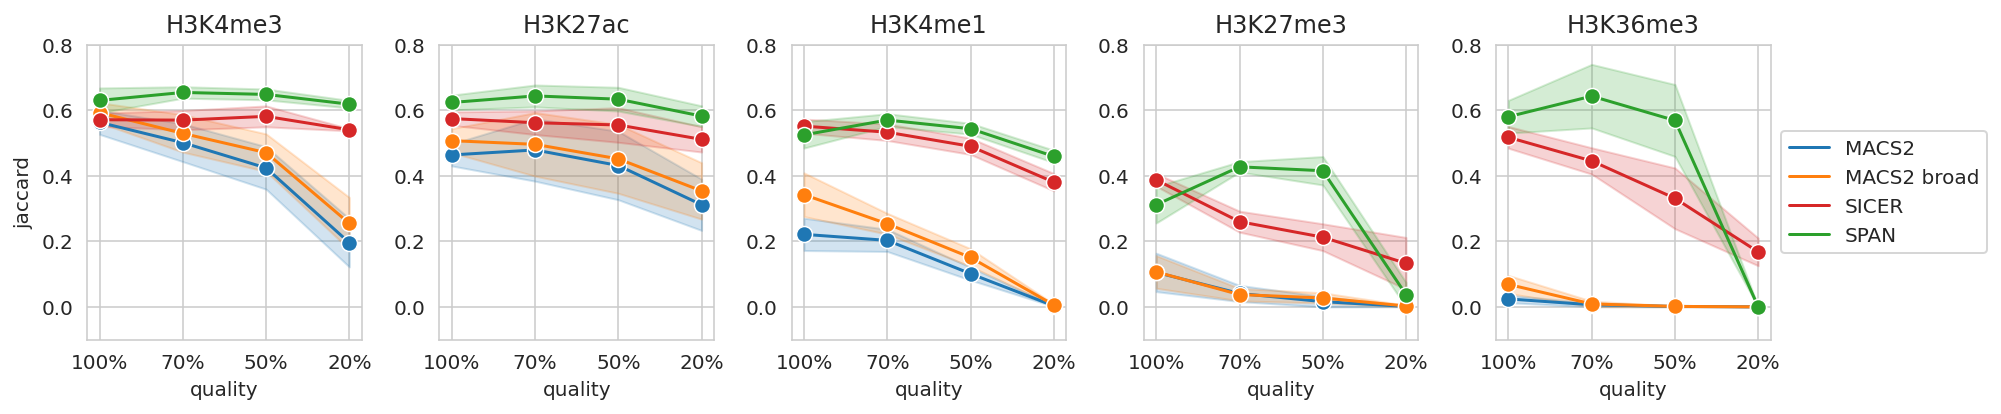

In [13]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=reps_overlap_all[(reps_overlap_all['modification'] == m) &
                                                   (reps_overlap_all['quality'] > 1)],
                             x='q', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax,
                             errorbar='se', marker='o', markersize=8
                             )
    g_results.axes.set_xticks(range(4), minor=False)
    # g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M'])
    g_results.axes.set_xticklabels(['100%', '70%', '50%', '20%'])
    g_results.axes.set_xlabel('quality')
    g_results.axes.set_ylabel('jaccard')
    g_results.axes.title.set_text(f'{m}')
    ax.set_ylim([-0.1, 0.8])
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 + f'/pics/replicates_jaccard_all3.pdf', bbox_inches='tight', dpi=300)
plt.show()

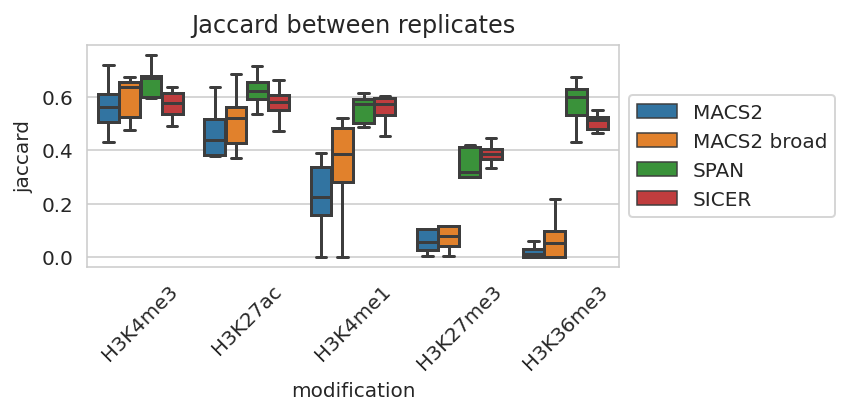

In [14]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=reps_overlap_all[reps_overlap_all['quality'] == 10],
                        x='modification', y='jaccard', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        )
ax = g_results.axes
ax.set_title('Jaccard between replicates')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 +  f'/pics/replicates_jaccard_all_original.pdf', bbox_inches='tight', dpi=300)
plt.show()

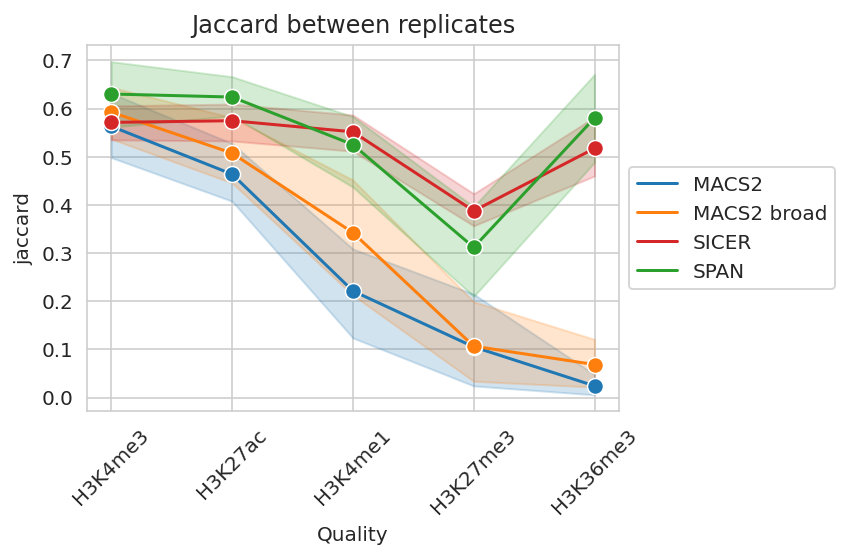

In [15]:
plt.figure(figsize=(6, 4))
g_results = sns.lineplot(data=reps_overlap_all[reps_overlap_all['quality'] == 10],
                         x='modification', y='jaccard', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         marker='o', markersize=8)
g_results.axes.set_xlabel('Quality')
g_results.axes.title.set_text(f'Jaccard between replicates')
g_results.axes.xaxis.set_tick_params(rotation=45)
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 +  f'/pics/replicates_jaccard_all_original2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Jaccard AUC

In [16]:
t = []
for m, c, tool in tqdm(product(reps_overlap_all['modification'].unique(),
                                  reps_overlap_all['cell'].unique(),
                                  reps_overlap_all['tool'].unique())):
    # print(c, r, tool)
    dft = reps_overlap_all[(reps_overlap_all['modification'] == m) &
                           (reps_overlap_all['cell'] == c) &
                           (reps_overlap_all['tool'] == tool)].copy()
    dft.sort_values(by=['q'], inplace=True)
    aj = 0
    qprev = 0
    for _, row in dft.iterrows():
        aj += (row['q'] - qprev) * row['jaccard']
        qprev = row['q']
        t.append((m, c, tool, aj))
dfjaccardrepsauc = pd.DataFrame(data=t, columns=['modification', 'cell', 'tool', 'AUC'])
dfjaccardrepsauc

0it [00:00, ?it/s]

,modification,cell,tool,AUC
0,H3K4me3,GM12878,MACS2,0.000000
1,H3K4me3,GM12878,MACS2,0.471802
2,H3K4me3,GM12878,MACS2,0.813468
3,H3K4me3,GM12878,MACS2,0.862418
4,H3K4me3,GM12878,MACS2,0.862418
...,...,...,...,...
359,H3K36me3,NHLF,SPAN,0.000000
360,H3K36me3,HepG2,MACS2,0.000000
361,H3K36me3,HepG2,MACS2 broad,0.000000
362,H3K36me3,HepG2,SICER,0.000000


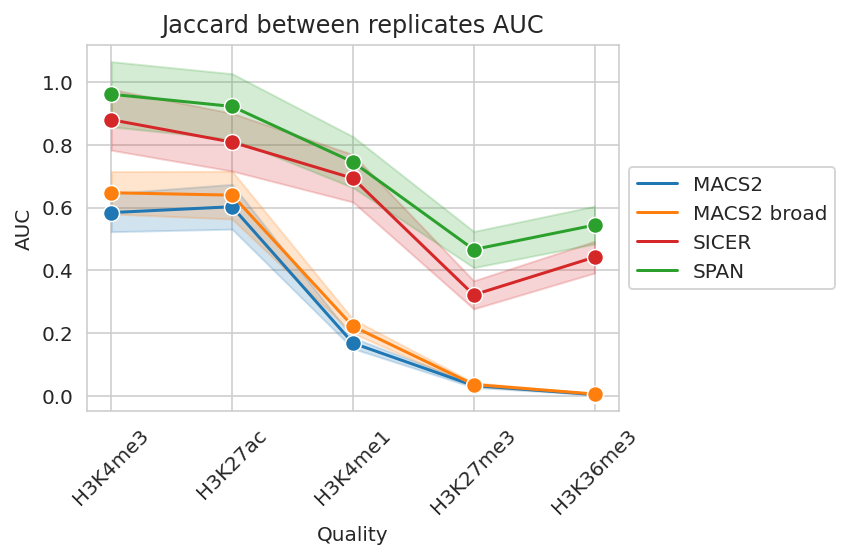

In [17]:
plt.figure(figsize=(6, 4))
g_results = sns.lineplot(data=dfjaccardrepsauc,
                         x='modification', y='AUC', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar=('se', 0.5), marker='o', markersize=8)
g_results.axes.set_xlabel('Quality')
g_results.axes.title.set_text(f'Jaccard between replicates AUC')
g_results.axes.xaxis.set_tick_params(rotation=45)
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(GSE26320_PATH_HG38 +  f'/pics/replicates_jaccard_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

# END